In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Oct 18

@author: yaning
"""

import HH_original as HH
import numpy as np
import matplotlib.pyplot as plt

0


this line runs
0.22356372458463003 4.0
this line runs
0.05819767068693265 0.125
this line runs
0.05819767068693265 0.125
Na -0.0
K 4.399733467282938
leak -3.1799999999999997
Na -0.007167112804423604
K 4.377373041628064
leak -3.198296002009244
Na -0.014256217697809935
K 4.355420317086788
leak -3.2158746509114597
Na -0.021194115791843163
K 4.333883507740796
leak -3.2327539926386226
Na -0.027935010398182764
K 4.312768000054084
leak -3.2489530236282778
Na -0.03445332934653955
K 4.292076985701729
leak -3.264491223118692
Na -0.04073801461851143
K 4.271811952154856
leak -3.2793882096172395
Na -0.046788114890099805
K 4.251973058394216
leak -3.293663495536026
Na -0.05260946676049453
K 4.232559420369245
leak -3.307336317255547
Na -0.05821224956956316
K 4.213569326989511
leak -3.3204255218008454
Na -0.06360922086551542
K 4.195000403493633
leak -3.3329494951351317
Na -0.06881447014796567
K 4.176849735453175
leak -3.344926120447527
Na -0.07384255976410098
K 4.159113963617862
leak -3.356372757620392

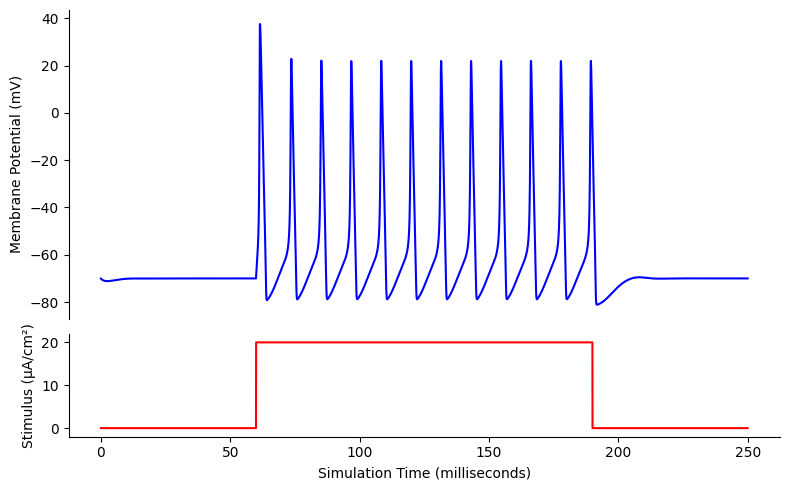

In [2]:
hh = HH.HHModel()
pointCount = 5000
voltages = np.empty(pointCount)
times = np.arange(pointCount) * 0.05
stim = np.zeros(pointCount)
stim[1200:3800] = 20  # create a square pulse

for i in range(len(times)):
    hh.Iterate(stimulusCurrent=stim[i], deltaTms=0.05)
    voltages[i] = hh.Vm
    # note: you could also plot hh's n, m, and k (channel open states)

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 5),
                                gridspec_kw={'height_ratios': [3, 1]})

ax1.plot(times, voltages - 70, 'b')
ax1.set_ylabel("Membrane Potential (mV)")
# ax1.set_title("Hodgkin-Huxley Spiking Neuron Model", fontSize=16)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.tick_params(bottom=False)

ax2.plot(times, stim, 'r')
ax2.set_ylabel("Stimulus (µA/cm²)")
ax2.set_xlabel("Simulation Time (milliseconds)")
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

plt.margins(0, 0.1)
plt.tight_layout()
# plt.savefig("dev/concept4.png")
plt.show()